In [27]:
import pandas as pd
from datetime import datetime
from tqdm.notebook import tqdm
import re
import seaborn as sn
import plotly_express as px
import random
from urllib.parse import urlparse

In [16]:
### sample data

In [17]:
df = pd.read_csv(r'Data_Quality_Log/Test_urls_new.csv')
df.head()

,id,SvivaUpdateDay,SvivaEventDate,Value
0,1,07/01/2012 00:00,06/01/2012 00:00,NaN
1,2,02/01/2012 00:00,02/01/2012 00:00,https://www.sport5.co.il/
2,3,07/01/2012 00:00,07/01/2012 00:00,https://www.bbc.com/sport/all-sports
3,4,NaN,01/01/1999 00:00,https://www.bb56c.com/sport/all-sports
4,5,###,01/01/1999 00:00,NaN


In [4]:
### Null Test

In [19]:
#### Extract url from string using REGEX

In [21]:
def Find_Url(string): 
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex,string)     
    url =list(dict.fromkeys([x[0] for x in url]))
    return url
###########################################################################
Find_Url('http://documents.sviva.gov.il/B001_3_160174_20190925_1030.pdf')[0]

'http://documents.sviva.gov.il/B001_3_160174_20190925_1030.pdf'

In [22]:
### detect response_code : 200- valid, 404 - inavild url 

In [24]:
def check_response_test(url):
    headers={
        "User-Agent" : "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"}    
    try:    
        r = requests.get(url,headers = headers)
        if(r.status_code == 200):
            return 'Valid_Link'
    except:
        return 'Invalid_Link'

In [25]:
### eror_logs_test -> main quality function that include:
####  Detect NULL,space/spaces 
####  Detect special characters 
####  checks if website address exist
####  check if value contains html tags
### Output of data quality  is error log file.

In [9]:
def eror_logs_test(df):
    col_name,index_list,eror_type,result_list,temp_list = ([] for i in range(5))
    col_names = df.columns
    num_of_iterations = list(range(len(col_names)))
    for i in tqdm(num_of_iterations,desc = 'progress'):
        for index,row in tqdm(df.iterrows()):###tqdm
            mask_space = len(' '.join(str(row[i]).split()))== 0
            special_char = re.sub('[!@#$%^&*(),.?":{}|<>]','',str(row[i]))
            tag_eror = ('>' in str(row[i]) or '<' in str(row[i]))
            now = str(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
            if (pd.isnull(row[i])!=True):
                if ((mask_space) or (str(row[i]).lower()=='null') or (pd.isnull(row[i]))):
                    result_list.append([random.randint(0,1000)]+[col_names[i]]+[index]+['space']+[row[i]]+[str(now)])
                elif(len(special_char)==0):
                    result_list.append([random.randint(0,1000)]+[col_names[i]]+[index]+['special_char']+[row[i]]+[str(now)])
                elif (len(Find_Url(str(row[i])))>0):    
                    try:
                        html = Find_Url(row[i])[0]
                        parsed_uri = urlparse(html)
                        if ('{uri.scheme}://{uri.netloc}'.format(uri=parsed_uri) not in temp_list):
                            temp_list.append('{uri.scheme}://{uri.netloc}'.format(uri=parsed_uri))
                            if (check_response_test(html) == 'Invalid_Link') :
                                result_list.append([random.randint(0,1000)]+[col_names[i]]+[index]+['Invalid_Link']+[html]+[str(now)])
                            else:
                                pass
                        else:
                            pass
                    except:
                        pass
                elif(tag_eror):
                        result_list.append([random.randint(0,1000)]+[col_names[i]]+[index]+['tag_eror']+[row[i]]+[str(now)])       
                elif(str(row[i]).lower()=='null'):
                    result_list.append([random.randint(0,1000)]+[col_names[i]]+[index]+['null']+[row[i]]+[str(now)])
            else:
                pass
    return result_list

In [26]:
## example of using data quality function ("eror_logs_test") on sample data

In [12]:
now = datetime.now()
df_results = eror_logs_test(df)
df_log = pd.DataFrame(df_results,columns = (['Test_Id','Col_name','index','Eror_Type','Value','Time']))
print (f' actul_run time is {datetime.now()-now}')



 actul_run time is 0:00:03.453726


In [13]:
df_log.head()

,Test_Id,Col_name,index,Eror_Type,Value,Time
0,825,SvivaUpdateDay,4,special_char,###,09/03/2022 17:27:57
1,518,Value,3,Invalid_Link,https://www.bb56c.com/sport/all-sports,09/03/2022 17:27:58
2,868,Value,7,Invalid_Link,https://www.sk89ysports.com/,09/03/2022 17:27:59
3,833,Value,11,space,,09/03/2022 17:27:59
4,901,Value,12,space,,09/03/2022 17:27:59


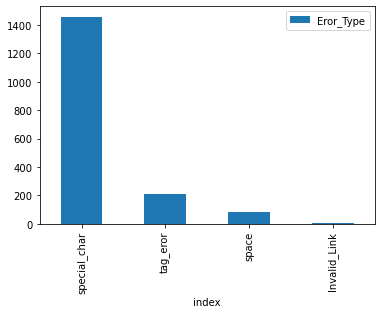

In [14]:
df_log.Eror_Type.value_counts().reset_index().plot(kind = 'bar',x= 'index', y = 'Eror_Type')

In [15]:
df_log.query('Eror_Type == "Invalid_Link"')

,Test_Id,Col_name,index,Eror_Type,Value,Time
1,518,Value,3,Invalid_Link,https://www.bb56c.com/sport/all-sports,09/03/2022 17:27:58
2,868,Value,7,Invalid_Link,https://www.sk89ysports.com/,09/03/2022 17:27:59
23,953,Value,49,Invalid_Link,https://www.sk4589ysports.com/,09/03/2022 17:27:59
35,199,Value,72,Invalid_Link,https://www.si565686mplypsychology.org/z-score...,09/03/2022 17:27:59
